<a href="https://colab.research.google.com/github/narhelmi/Hyperparameter_optimization_narges/blob/main/Hyperparameter_optimization1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91353    0 91353    0     0   129k      0 --:--:-- --:--:-- --:--:--  129k
Archive:  wine+quality.zip
  inflating: winequality-red.csv     
  inflating: winequality-white.csv   
  inflating: winequality.names       
sample_data  winequality.names	winequality-red.csv  winequality-white.csv  wine+quality.zip
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulf

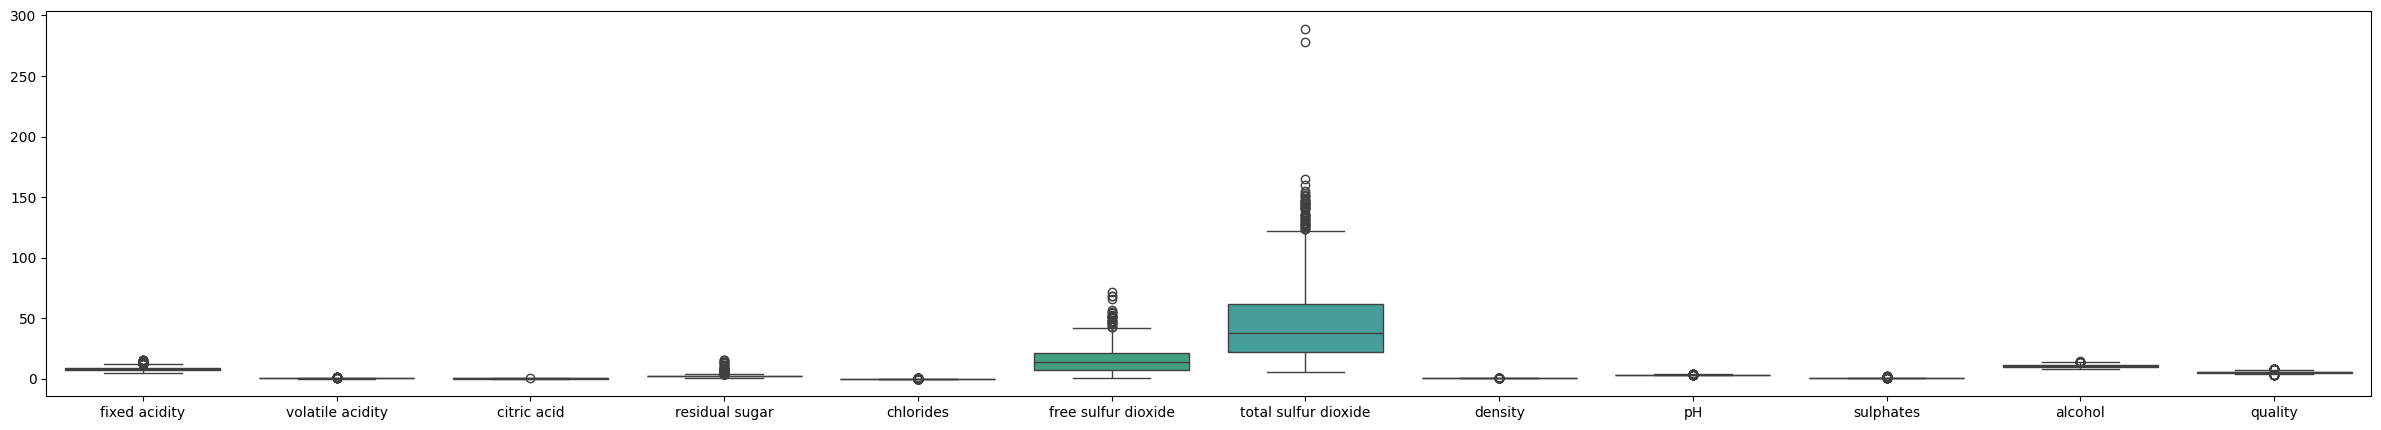

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint

# Download dataset
!curl https://archive.ics.uci.edu/static/public/186/wine+quality.zip -O -J -L && unzip -o wine+quality.zip
!ls

# Load the dataset
path = './winequality-red.csv'
df = pd.read_csv(path, delimiter=';')

# Display dataset
print(df.info())
print(df.sample())


plt.figure(figsize=(30, 5))
sns.boxplot(data=df)
plt.show()

# Data preprocessing
X = df.drop('quality', axis=1)
Y = df['quality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [ ]:
# Initial Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Initial Accuracy: {initial_accuracy}')

# Define hyperparameter search space for Random Forest
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 100),
    'min_samples_split': randint(2, 100),
    'min_samples_leaf': randint(1, 4)
}

# Hyperparameter tuning with RandomizedSearchCV
def evaluate_random_forest(model, param_distributions, n_iter=20, cv=5):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        random_state=42,
        error_score='raise',
        return_train_score=True
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results = random_search.cv_results_
    results_df = pd.DataFrame({
        'iter': range(1, n_iter + 1),
        'accuracy': results['mean_test_score'],
        'max_depth': results['param_max_depth'],
        'min_samples_split': results['param_min_samples_split'],
        'min_samples_leaf': results['param_min_samples_leaf'],
        'n_estimators': results['param_n_estimators']
    })

    return accuracy, random_search.best_params_, results_df

# Evaluate Random Forest with hyperparameter tuning
tuned_accuracy, best_params, results_df = evaluate_random_forest(model, param_distributions, n_iter=20)

# Display the results as a table
print(results_df)

# Identify the iteration with the highest accuracy
print("Best hyperparameters for RandomForest:")

best_iter = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best hyperparameters for RandomForest: {best_iter}")

Random Forest Initial Accuracy: 0.65
    iter  accuracy max_depth min_samples_split min_samples_leaf n_estimators
0      1  0.663061        54                16                1          206
1      2  0.660711        74                22                1          714
2      3  0.630218        85                76                3          558
3      4  0.649761        90                25                1          230
4      5  0.692770        24                 3                1          443
5      6  0.689632        32                 3                2          291
6      7  0.655248        62                34                1          559
7      8  0.624740        60                90                2          660
8      9  0.643511        93                43                3          575
9     10  0.630999        62                63                3          786
10    11  0.634917        64                56                3          343
11    12  0.692770        66           

In [ ]:
# Initial SVM model
model = SVC(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Initial Accuracy: {initial_accuracy}')

# Define hyperparameter search space for SVM
param_distributions = {
    'C': loguniform(1, 1e2),
    'gamma': loguniform(1e-3, 1e0)
}

# Hyperparameter tuning with RandomizedSearchCV
def evaluate_svm(model, param_distributions, n_iter=100, cv=5):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        random_state=42,
        error_score='raise',
        return_train_score=True
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results = random_search.cv_results_
    results_df = pd.DataFrame({
        'iter': range(1, len(results['mean_test_score']) + 1),
        'accuracy': results['mean_test_score'],
        'C': results['param_C'],
        'gamma': results['param_gamma'],
    })

    return accuracy, random_search.best_params_, results_df

# Evaluate SVM with hyperparameter tuning
tuned_accuracy, best_params, results_df = evaluate_svm(model, param_distributions, n_iter=100)

# Display the results as a table
print(results_df)

# Identify the iteration with the highest accuracy
best_iter = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best hyperparameters for SVM: {best_iter}")



SVM Initial Accuracy: 0.603125
    iter  accuracy          C     gamma
0      1  0.643508   5.611516  0.711448
1      2  0.624755  29.106359  0.062514
2      3  0.579418   2.051338  0.002938
3      4  0.646627   1.306674  0.396761
4      5  0.623968  15.930523  0.133112
..   ...       ...        ...       ...
95    96  0.653658   1.535343   0.49164
96    97  0.614589  63.217325  0.079306
97    98  0.589568   4.764964  0.011159
98    99  0.630999  28.308141  0.491282
99   100  0.609093  59.452873  0.218588

[100 rows x 4 columns]
Best hyperparameters for SVM: iter              17
accuracy    0.656011
C           1.349283
gamma       0.702517
Name: 16, dtype: object


In [ ]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f'GB Initial Accuracy: {initial_accuracy}')

# Define hyperparameter search space for Gradient Boosting
param_distributions = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.9),
    'max_depth': randint(3, 10),
}

# Hyperparameter tuning with RandomizedSearchCV
def evaluate_gb(model, param_distributions, n_iter=20, cv=5):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        random_state=42,
        error_score='raise',
        return_train_score=True
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results = random_search.cv_results_
    results_df = pd.DataFrame({
        'iter': range(1, len(results['mean_test_score']) + 1),
        'accuracy': results['mean_test_score'],
        'n_estimators': results['param_n_estimators'],
        'learning_rate': results['param_learning_rate'],
        'max_depth': results['param_max_depth'],
    })

    return accuracy, random_search.best_params_, results_df

# Evaluate Gradient Boosting with hyperparameter tuning
tuned_accuracy, best_params, results_df = evaluate_gb(model, param_distributions, n_iter=20)

# Display the results as a table
print(results_df)

# Identify the iteration with the highest accuracy
best_iter = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best hyperparameters for GB: {best_iter}")


GB Initial Accuracy: 0.646875
    iter  accuracy n_estimators learning_rate max_depth
0      1  0.670885          114      0.347086         7
1      2  0.647420          120      0.668795         7
2      3  0.671651          174      0.150417         5
3      4  0.658361          199      0.423324         7
4      5  0.668526          249       0.13858         5
5      6  0.675551          257       0.06077         6
6      7  0.677914          120      0.201105         6
7      8  0.663042          121      0.565733         4
8      9  0.626314          148       0.01636         3
9     10  0.663839          269      0.482297         9
10    11  0.672433          114      0.051999         6
11    12  0.656808          289      0.420463         9
12    13  0.663839          163      0.189706         9
13    14  0.659908          150      0.430087         7
14    15  0.645824          266      0.622277         3
15    16  0.633346          159      0.021938         3
16    17  0.660680

In [ ]:
# Deciosn Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f'DT Initial Accuracy: {initial_accuracy}')

# Define hyperparameter search space for Gradient Boosting
param_distributions = {
   'max_depth': randint(3, 20),
    'min_samples_split': randint(3, 20),
    'min_samples_leaf': randint(3, 10)
}

# Hyperparameter tuning with RandomizedSearchCV
def evaluate_dt (model, param_distributions, n_iter=20, cv=5):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        random_state=42,
        error_score='raise',
        return_train_score=True
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results = random_search.cv_results_
    results_df = pd.DataFrame({
        'iter': range(1, len(results['mean_test_score']) + 1),
        'accuracy': results['mean_test_score'],
        'max_depth': results['param_max_depth'],
        'min_samples_split': results['param_min_samples_split'],
        'min_samples_leaf': results['param_min_samples_leaf'],
    })

    return accuracy, random_search.best_params_, results_df

# Evaluate Gradient Boosting with hyperparameter tuning
tuned_accuracy, best_params, results_df = evaluate_dt (model, param_distributions, n_iter=20)

# Display the results as a table
print(results_df)

# Identify the iteration with the highest accuracy
best_iter = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best hyperparameters for dt: {best_iter}")

DT Initial Accuracy: 0.5625
    iter  accuracy max_depth min_samples_split min_samples_leaf
0      1  0.572328         9                17                6
1      2  0.578603        13                 9                7
2      3  0.551982        13                 6                5
3      4  0.560576        10                 4                5
4      5  0.584069        14                 8                8
5      6  0.596575         4                 3                6
6      7  0.560604        14                14                4
7      8  0.553536        19                12                5
8      9  0.577806        18                17                9
9     10  0.577806        14                 5                9
10    11  0.581679         7                 9                5
11    12  0.581713        11                 6                9
12    13  0.558254        16                11                4
13    14  0.596575         4                17                6
14    15  0.

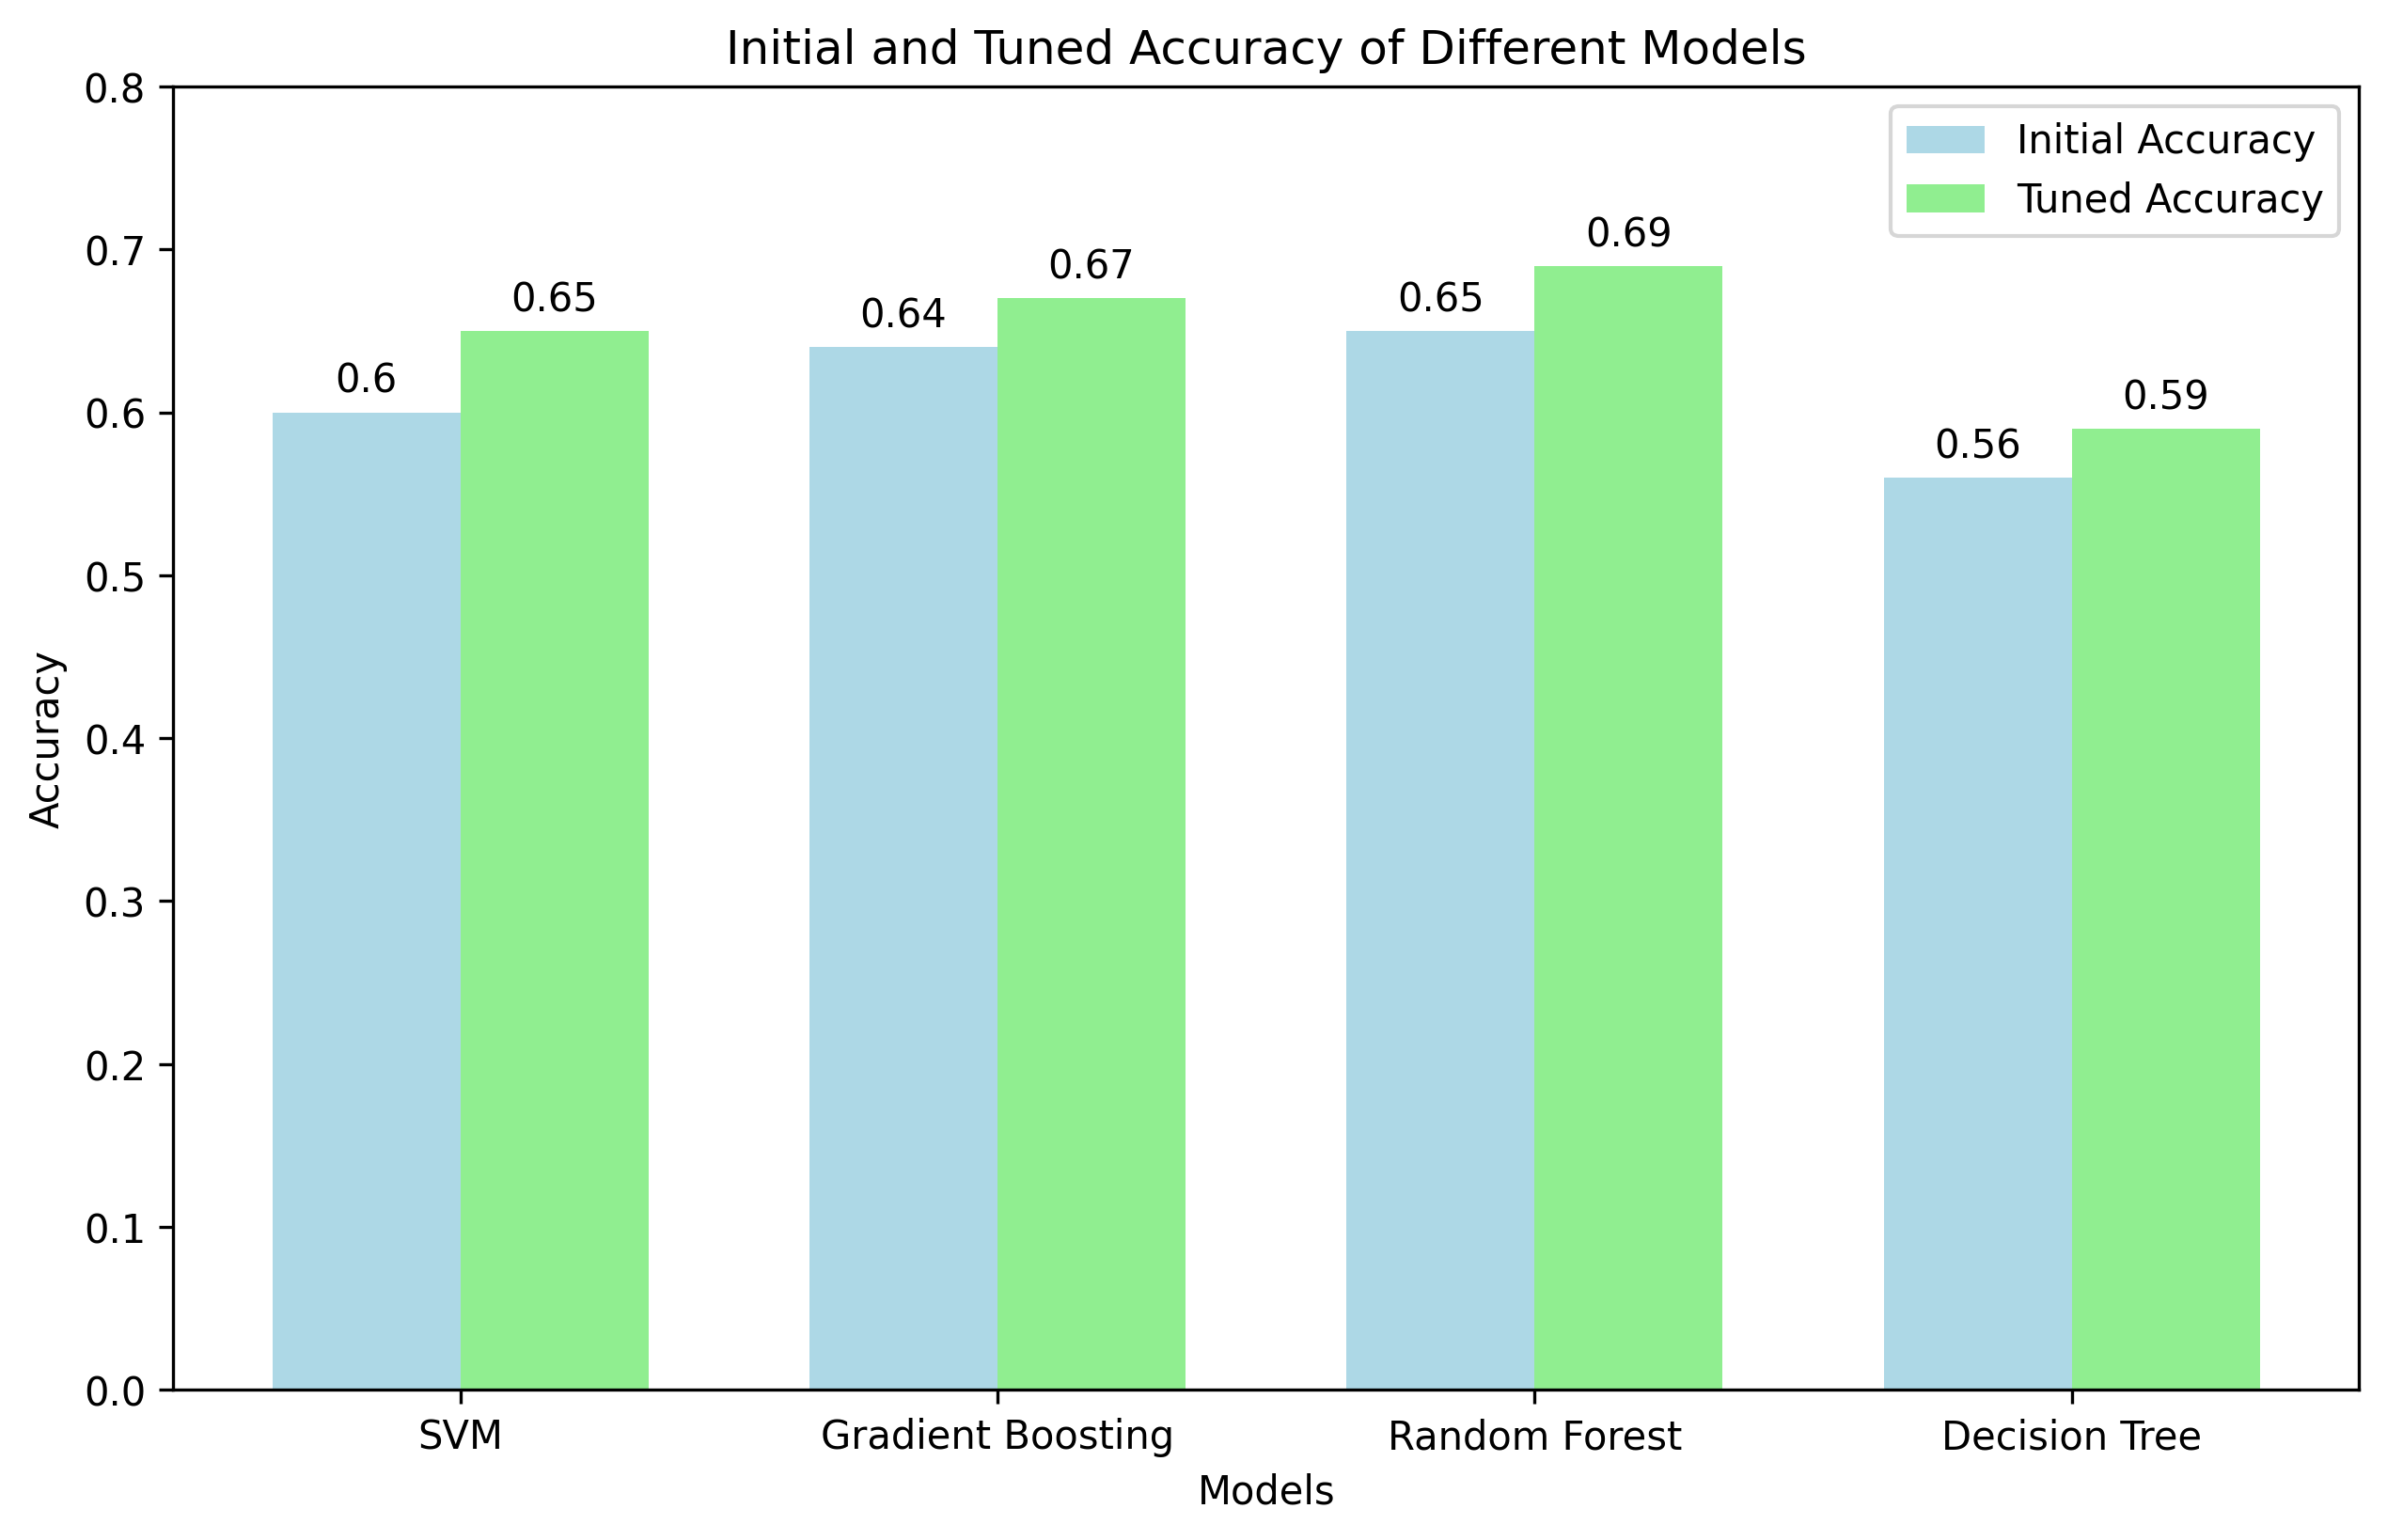

In [ ]:
# Define the initial and best tuned accuracies for each model
models_results_initial = {
    'SVM': 0.60,
    'Gradient Boosting': 0.64,
    'Random Forest': 0.65,
    'Decision Tree': 0.56
}

models_results_hy = {
    'SVM': 0.65,
    'Gradient Boosting': 0.67,
    'Random Forest': 0.69,
    'Decision Tree': 0.59
}

# Get the list of models
models = list(models_results_initial.keys())

# Convert the accuracy values to lists
initial_acc = list(models_results_initial.values())
tuned_acc = list(models_results_hy.values())

# Define the x-axis positions for the groups
x = np.arange(len(models))
width = 0.35  # Width of the bars

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
bars1 = ax.bar(x - width/2, initial_acc, width, label='Initial Accuracy', color='lightblue')
bars2 = ax.bar(x + width/2, tuned_acc, width, label='Tuned Accuracy', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Initial and Tuned Accuracy of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Attach a text label above each bar in bars1 and bars2, displaying its height
ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)

plt.ylim(0, 0.8)  # Adjust the y-axis limit if needed
plt.show()